In [0]:
import os
import re
import glob
import datetime
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm

import multiprocessing
from multiprocessing.dummy import Pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.base import clone

import xgboost as xgb
import lightgbm as lgb

In [69]:
cpu_count  = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 3


In [0]:
seed=42
np.random.seed(seed)

# Download Dataset

In [71]:
use_colab = True
print('Using Google Colab: {}'.format(use_colab))

if use_colab:

    from googleapiclient.discovery import build
    import io, os
    from googleapiclient.http import MediaIoBaseDownload
    from google.colab import auth

    if not os.path.exists('../input/'):

        auth.authenticate_user()

        drive_service = build('drive', 'v3')
        results = drive_service.files().list(
                q="name = 'kaggle.json'", fields="files(id)").execute()
        kaggle_api_key = results.get('files', [])

        filename = "/content/.kaggle/kaggle.json"
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
        fh = io.FileIO(filename, 'wb')
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print("Download %d%%." % int(status.progress() * 100))
        os.chmod(filename, 600)

        !pip install kaggle
        !kaggle competitions download -c santander-value-prediction-challenge -p ../input/
        !cd ../input && unzip sample_submission.csv.zip && unzip test.csv.zip && unzip train.csv.zip

    else:
        print('Dataset already downloaded!')

Using Google Colab: True
Dataset already downloaded!


In [0]:
path2train = '../input/train.csv'
path2test = '../input/test.csv'

In [0]:
df_train = pd.read_csv(path2train)
df_test = pd.read_csv(path2test)

In [74]:
df_train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


## Data Pre-processing

In [75]:
# check columns withs nan values
col_nan = df_train.columns[df_train.isna().any()].tolist()
if len(col_nan) == 0:
    print('Data has no Nan values')
else:
  print('Data has Nan vaulues in cols: {}'.format(col_nan))

Data has no Nan values


In [0]:
df_col = df_train.columns[2:]

In [0]:
# Remove constant columns
const_col = []
for col in df_col:
    if df_train[col].std() == 0:
        const_col.append(col)

In [0]:
df_train = df_train.drop(const_col, axis=1)
df_test = df_test.drop(const_col, axis=1)

In [79]:
print('Train DataFrame shape: {}'.format(df_train.shape))
print('Test DataFrame shape: {}'.format(df_test.shape))

Train DataFrame shape: (4459, 4737)
Test DataFrame shape: (49342, 4736)


In [0]:
df_col = df_train.columns[2:]

In [0]:
def get_duplicate_columns(df):

    equals_col = []
    for i in tqdm(range(0, len(df_col))):
        ba = df[df_col[i]].values
        for j in range(i + 1, len(df_col)):
            aa = df[df_col[j]].values
            if (np.array_equal(ba, aa)):
                equals_col.append(df_col[j])
    return equals_col

In [84]:
equals_col = get_duplicate_columns(df_train)

100%|██████████| 4735/4735 [03:33<00:00, 22.13it/s]


In [85]:
print('There are {} columns which are equals'.format(len(equals_col)))
print(equals_col)

There are 6 columns which are equals
['d60ddde1b', 'acc5b709d', 'f333a5f60', 'f8d75792f', '912836770', 'f333a5f60']


In [0]:
df_train = df_train.drop(equals_col, axis=1)
df_test = df_test.drop(equals_col, axis=1)

In [88]:
print('Train DataFrame shape: {}'.format(df_train.shape))
print('Test DataFrame shape: {}'.format(df_test.shape))

Train DataFrame shape: (4459, 4732)
Test DataFrame shape: (49342, 4731)


# Features selection
  
  -  Get the features which are most correlated with the target value


In [0]:
def get_most_correlated_features_target(df_train, features_limit = 100):

    aux_lst = []
    features_col = df_train.columns[2:]

    for fc in features_col:
        aux_lst.append(df_train['target'].corr(df_train[fc]))


    corre_features = pd.DataFrame({'Column':features_col, 'Correlation':aux_lst}
                                 ).sort_values('Correlation', ascending=False)
    
    
    
    most_correlated_features = corre_features[:features_limit]
    
    return most_correlated_features

In [0]:
def filter_data(df_train, df_test, most_correlated_features):
  
    most_correlated_features = most_correlated_features['Column'].values
  
    df_train_tune = pd.DataFrame()
    df_train_tune[['ID', 'target']] =  df_train[['ID', 'target']]
    df_train_tune[most_correlated_features] = df_train[most_correlated_features]

    df_test_tune = pd.DataFrame()
    df_test_tune[['ID']] =  df_test[['ID']]
    df_test_tune[most_correlated_features] = df_test[most_correlated_features]

    
    return df_train_tune, df_test_tune

In [93]:
most_correlated_features = get_most_correlated_features_target(df_train, features_limit= 250)
most_correlated_features.head()

,Column,Correlation
4472,555f18bd3,0.273379
2616,9fd594eec,0.270019
2342,5bc7ab64f,0.267858
3334,cbbc9c431,0.265005
4131,f190486d6,0.263821


In [0]:
df_train, df_test = filter_data(df_train, df_test, most_correlated_features)

In [95]:
df_train.head()

,ID,target,555f18bd3,9fd594eec,5bc7ab64f,cbbc9c431,f190486d6,6b119d8ce,f74e8f13d,ac30af84a,...,3f4a39818,9282e1543,961b91fe7,b4cfe861f,b5a25e7c9,6c0e0801a,3bdee45be,621833d9b,f6c436744,e25a65f3d
0,000d6aaf2,38000000.0,0.0,600000.0,0.0,0.0,1866666.66,0.0,1733333.34,0.0,...,550000.0,0,0.0,0.0,0,0.0,22000000.0,0.0,0,0
1,000fbd867,600000.0,0.0,1800000.0,0.0,0.0,0.00,0.0,0.00,0.0,...,2000000.0,0,0.0,0.0,0,2225000.0,0.0,0.0,0,0
2,0027d6b71,10000000.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0
3,0028cbf45,2000000.0,0.0,0.0,0.0,0.0,2000000.00,0.0,0.00,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0
4,002a68644,14400000.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0


In [0]:
def data_corr(data):
    fig = plt.figure(figsize=(15,10))
    correlation = data.corr()
    sns.heatmap(correlation, annot=False, cbar=True, cmap="RdYlGn")

In [0]:
#data_corr(df_train[2:])

In [0]:
y = np.log1p(df_train['target'].values)
X = df_train[df_train.columns.drop(['ID','target'])].values

IdTest = df_test['ID'].values
X_test = df_test[df_test.columns.drop(['ID'])].values

Text(0.5,1,'log(1 + T)')

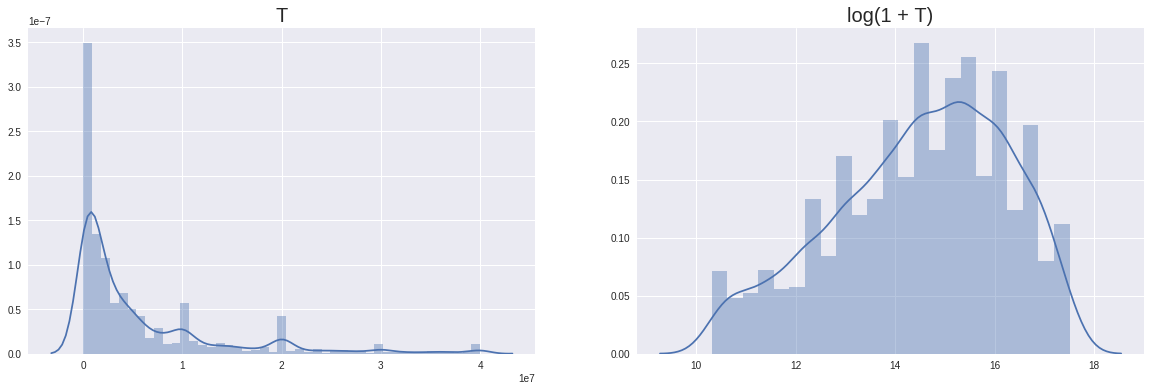

In [99]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.distplot(df_train['target'].values)
plt.title('T', fontsize=20)
plt.subplot(1,2,2)
sns.distplot(y)
plt.title('log(1 + T)', fontsize=20)

In [0]:
def find_ncluster(X, kmax=20):

    wcss = []    
    for i in tqdm(range(2, kmax)):
        kmeans = MiniBatchKMeans(n_clusters = i, init = 'k-means++',
                                 n_init=1,init_size= int(1e3),
                                 random_state = 42,batch_size=int(1e3))
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.figure()      
    plt.plot(range(2, kmax), wcss, '-o')
    plt.title('The Elbow Method (WCSS)')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.grid('on')

In [0]:
#ind_ncluster(X)

**Split dataset**

In [102]:
test_size = 0.2
print('Valid size: {}'.format(test_size))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

Valid size: 0.2


In [103]:
print('X train shape: {}'.format(X_train.shape))
print('y train shape: {}'.format(y_train.shape))

print('X valid shape: {}'.format(X_valid.shape))
print('y valid shape: {}'.format(y_valid.shape))

print('X test shape: {}'.format(X_test.shape))

X train shape: (3567, 250)
y train shape: (3567,)
X valid shape: (892, 250)
y valid shape: (892,)
X test shape: (49342, 250)


**Data Normalization**

In [0]:
normalization_type = 'zScore'

In [105]:
print('Normalization type: {}'.format(normalization_type))

if normalization_type == 'minMax':
    scaler = MinMaxScaler()
    
elif normalization_type == 'zScore':        
    scaler =  StandardScaler()

Normalization type: zScore


In [0]:
## data normalization
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)   

**Define regression model**

In [0]:
boost_params = {'eval_metric': 'rmse'}

model_xgb = xgb.XGBRegressor(
    max_depth=10, learning_rate=0.01,
    n_estimators=1000, objective='reg:linear',
    gamma=0, min_child_weight=1,
    subsample=1, colsample_bytree=1,
    scale_pos_weight=1, seed=27,
    **boost_params)

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=15,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [0]:
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.median(predictions, axis=1)   

In [0]:
averaged_models = AveragingModels(models = [model_xgb, model_lgb])

In [117]:
averaged_models.fit(X_train, y_train)

In [0]:
def plot_features_importance(cols, importance, most_important = 40):

    df = pd.DataFrame({'cols':cols, 'imp':importance}
                       ).sort_values('imp', ascending=False)
    df[:most_important].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [0]:
#plot_features_importance(df_train.columns[2:], model.feature_importances_)

**Model's evaluation**

In [0]:
#from https://www.kaggle.com/marknagelberg/rmsle-function

def rmsle(y_pred, y):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [0]:
def evaluate_regression(ypred, ytrue):
    mse_eval = mse(ypred, ytrue)
    mae_eval = mae(ypred, ytrue)
    rmsle_eval = rmsle(ypred, ytrue)
    
    print('Mean Squared Error: {}'.format(mse_eval))
    print('Mean Absolute Error: {}'.format(mae_eval))
    print('Root Mean Squared Logarithmic Error: {}'.format(rmsle_eval))

In [122]:
ypred_train = averaged_models.predict(X_train)
evaluate_regression(ypred_train, y_train)

Mean Squared Error: 0.6841092130590777
Mean Absolute Error: 0.5324019589167557
Root Mean Squared Logarithmic Error: 0.05565167323377451


In [0]:
def generate_submission(ID, ypred):
    
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    sub = pd.DataFrame({'ID': ID})
    sub['target'] = ypred

    sub.to_csv(sub_file, index=False)
    print('Submission File saved: {}'.format(sub_file))

In [0]:
ypred_test = averaged_models.predict(X_test)
ypred_test = np.expm1( ypred_test )

In [125]:
generate_submission(IdTest, ypred_test)

Submission File saved: subm/submission_2018-07-18-01-46.csv


In [127]:
df_submission = pd.read_csv('subm/submission_2018-07-18-01-46.csv')
df_submission.head()

,ID,target
0,000137c73,1.724120e+06
1,00021489f,1.919486e+06
2,0004d7953,3.199649e+06
3,00056a333,5.707595e+06
4,00056d8eb,1.919486e+06


In [128]:
!kaggle competitions submit -c santander-value-prediction-challenge -f "subm/submission_2018-07-18-01-46.csv" -m "averaging_2018-07-18-01-46"

Successfully submitted to Santander Value Prediction Challenge